# Assignment 1: Plotting grad-CAM images of any 50 misclassified objects of cifar10 dataset.

**Objective:** Use pretrained model (trained with cifar10 dataset)

**Procedure:** Use the pretrained model on cifar10. I took the model submitted for Assignment 9A of EVA class which is a simple sequential CNN model. The validation accuracy for this model is about 86%.






In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, SpatialDropout2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import *

from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator 

import sys

from skimage import io
import cv2
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
import random

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# !ls '/content/gdrive/My Drive/'
!mkdir ~/.keras/datasets
!cp '/content/gdrive/My Drive/cifar-10-python.tar.gz' ~/.keras/datasets/cifar-10-batches-py.tar.gz

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
x_train = train_features
y_train = train_labels
x_test = test_features
y_test = test_labels

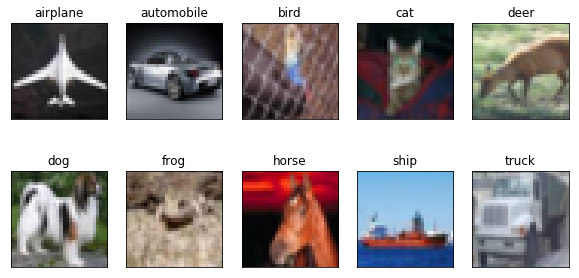

In [6]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
class_labels = list(range(10))
fig = plt.figure(figsize=(10,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# This cell is to generate random indices for train and test data -- to demonstrate the implementation of gradCAM
# This selection is based on the class labels
import random

train_set_f = [np.where(train_labels[:] == i) for i in class_labels]
test_set_f = [np.where(test_labels[:] == i) for i in class_labels]
train_set_features = [train_set_f[i][0] for i in class_labels]
test_set_features = [test_set_f[i][0] for i in class_labels]

clabels = random.choices(class_labels, k=2)
train_c = [random.choices(train_set_features[i], k=1) for i in clabels]
clabels = random.choices(class_labels, k=2)
test_c = [random.choices(test_set_features[i], k=1) for i in clabels]
train_clist = [item for sublist in train_c for item in sublist]
test_clist = [item for sublist in test_c for item in sublist]

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')
test_features = test_features.astype('float32')
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [11]:
train_features.shape, train_labels.shape, test_features.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [0]:
from keras.callbacks import *
filepath="/content/gdrive/My Drive/eip3ph2/assignments/a1_v2/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=3)

In [0]:
weight_decay=1e-6
space_dropout = 0.125
px_dropout=0.2
lr_initial = 0.015

In [0]:
def scheduler(epoch, lr):
  
  if lr > 9e-5:
    learn_rate = round(lr/(1 + 0.0025 * epoch), 9)
    return learn_rate
  else:
    start  = lr_initial / 10
    learn_rate = round(start/(1 + 0.0025 * epoch), 9)
    return learn_rate

lr_schedule = LearningRateScheduler(scheduler, verbose=1)

In [15]:
batch_size = 125
train_datagen = ImageDataGenerator(featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   zoom_range=0.0,
                                   horizontal_flip=False)
train_generator = train_datagen.flow(train_features, train_labels, batch_size, shuffle=True)
train_datagen.fit(train_features)
train_datagen.mean, train_datagen.std

(array([[[125.3069 , 122.95015, 113.866  ]]], dtype=float32),
 array([[[62.993256, 62.08861 , 66.705   ]]], dtype=float32))

In [0]:
test_datagen = ImageDataGenerator()
test_features = (test_features - train_datagen.mean) / (train_datagen.std + 1e-7)
test_generator = test_datagen.flow(test_features, test_labels, batch_size, shuffle=False)
test_steps = test_generator.n // test_generator.batch_size

In [42]:
test_steps, batch_size, train_generator.n // train_generator.batch_size

(80, 125, 400)

In [18]:
# Define the model
model = Sequential()

# input size = 32 x 32 x 3
model.add(Conv2D(64, (3, 3), use_bias=False, name='in_layer1', padding='same', input_shape=(32, 32, 3), kernel_regularizer=l2(weight_decay))) # RF 3 x 3
# output_size = 32 x 32 x 64
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(SpatialDropout2D(space_dropout))

model.add(Conv2D(128, (3, 3), use_bias=False, name='in_layer2', kernel_regularizer=l2(weight_decay))) # Input = 32 x 32 x 64, RF 5 x 5
# output_size = 30 x 30 x 128
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(SpatialDropout2D(space_dropout))

model.add(Conv2D(30, (1, 1), use_bias=False, name='in_layer3', kernel_regularizer=l2(weight_decay))) # Input = 30 x 30 x 128, RF 5 x 5
# output_size = 30 x 30 x 30
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
# model.add(Dropout(dropout))

model.add(MaxPooling2D(pool_size=(2, 2), name='mp1')) # Input = 30 x 30 x 30, RF 10 x 10
# output_size = 15 x 15 x 30
model.add(Dropout(px_dropout))


model.add(Conv2D(128, (3, 3), use_bias=False, name='mid_1', padding='same', kernel_regularizer=l2(weight_decay))) # Input = 15 x 15 x 30, RF 12 x 12
# output_size = 15 x 15 x 128
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(SpatialDropout2D(space_dropout))

model.add(Conv2D(64, (1, 1), use_bias=False, name='mid_1_1', kernel_regularizer=l2(weight_decay))) # Input = 15 x 15 x 128, RF 12 x 12
# output_size = 15 x 15 x 64
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(SpatialDropout2D(space_dropout))


model.add(Conv2D(256, (3, 3), use_bias=False, name='mid_2', kernel_regularizer=l2(weight_decay))) # Input = 15 x 15 x 64, RF 14 x 14
# output_size = 13 x 13 x 256
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
# model.add(Dropout(dropout))

model.add(Conv2D(64, (1, 1), use_bias=False, name='mid_1_2', kernel_regularizer=l2(weight_decay))) # Input = 13 x 13 x 256, RF 14 x 14
# output_size = 13 x 13 x 64
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Dropout(px_dropout))

model.add(Conv2D(512, (3, 3), use_bias=False, name='mid_3', kernel_regularizer=l2(weight_decay))) # Input = 13 x 13 x 64, RF 16 x 16
# output_size = 11 x 11 x 512
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
# model.add(Dropout(dropout))

model.add(Conv2D(30, (1, 1), use_bias=False, name='mid_4', kernel_regularizer=l2(weight_decay))) # Input = 11 x 11 x 512, RF 16 x 16
# output_size = 11 x 11 x 30
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
# model.add(Dropout(dropout))


model.add(MaxPooling2D(pool_size=(2, 2), name='mp2')) # Input = 11 x 11 x 30, RF 32 x 32
# output_size = 5 x 5 x 30
model.add(Dropout(px_dropout))


model.add(Conv2D(128, (3, 3), use_bias=False, name='out_layer4', padding='same', kernel_regularizer=l2(weight_decay))) # Input = 5 x 5 x 30, RF 34 x 34
# output_size = 5 x 5 x 128
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(SpatialDropout2D(space_dropout))

model.add(Conv2D(256, (3, 3), use_bias=False, name='out_layer3', padding='same', kernel_regularizer=l2(weight_decay))) # Input = 5 x 5 x 96, RF 36 x 36
# output_size = 5 x 5 x 256
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(SpatialDropout2D(space_dropout))

model.add(Conv2D(30, (1, 1), use_bias=False, name='out_layer2', kernel_regularizer=l2(weight_decay))) # Input = 5 x 5 x 256, RF 36 x 36
# output_size = 5 x 5 x 30
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Dropout(px_dropout))

model.add(Conv2D(10, (5, 5), use_bias=False, name='out_layer1', kernel_regularizer=l2(weight_decay))) # Input = 5 x 5 x 30, RF 40 x 40
# output_size = 1 x 1 x 10
# model.add(BatchNormalization(axis=-1))
# model.add(Activation('relu'))
# model.add(Dropout(dropout))

model.add(Flatten())
model.add(Activation('softmax'))

W0713 06:45:41.929247 140455452694400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 06:45:41.977758 140455452694400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 06:45:41.986249 140455452694400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0713 06:45:42.041509 140455452694400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0713 06:45:42.042715 1404554526

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in_layer1 (Conv2D)           (None, 32, 32, 64)        1728      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 32, 32, 64)        0         
_________________________________________________________________
in_layer2 (Conv2D)           (None, 30, 30, 128)       73728     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 128)       0         
__________

In [20]:
# train_generator.reset, test_generator.reset
test_steps, np.ceil(len(test_features)/batch_size)

(80, 80.0)

In [21]:
# Compile the model
model.compile(optimizer=Adam(lr = lr_initial), loss='categorical_crossentropy', metrics=['accuracy'])

W0713 06:46:31.077862 140455452694400 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



W0713 06:48:18.804156 140455452694400 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.015.
400/400 [==============================] - 66s 166ms/step - loss: 2.1264 - acc: 0.2209 - val_loss: 1.8126 - val_acc: 0.3203
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.014962593.
400/400 [==============================] - 60s 150ms/step - loss: 1.7044 - acc: 0.3744 - val_loss: 1.5738 - val_acc: 0.4371
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.014888152.
400/400 [==============================] - 60s 150ms/step - loss: 1.5025 - acc: 0.4619 - val_loss: 1.3397 - val_acc: 0.5177

Epoch 00003: val_acc improved from -inf to 0.51770, saving model to /content/gdrive/My Drive/eip3ph2/assignments/a1_v2/weights-improvement-03-0.52.hdf5
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 0.014777322.
400/400 [==============================] - 60s 150ms/step - loss: 1.3617 - acc: 0.5195 - val_loss: 1.2672 - val_acc: 0.5572
Epoch 5/30

Epoch

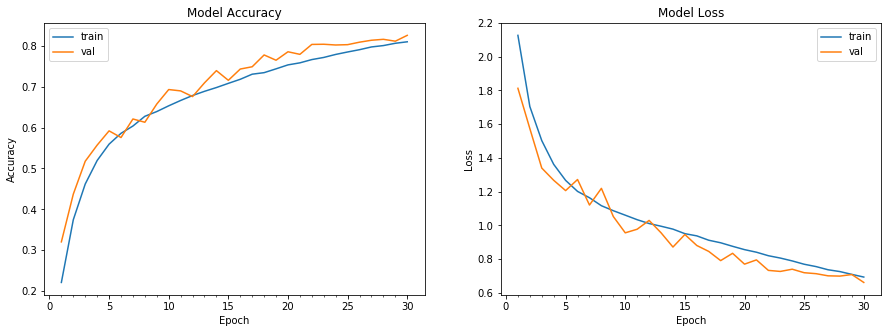

Accuracy on test data is: 82.60


In [22]:
# Model Execution is commented out to avoid re-running the model with same ('everything') architecture and parameters

'''
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(train_generator, shuffle=True,
                                 steps_per_epoch = len(train_features)//batch_size, epochs = 30, 
                                 validation_data = test_generator, validation_steps = test_steps, callbacks = [lr_schedule, checkpoint], verbose=1)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

'''

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.00518796.
400/400 [==============================] - 60s 150ms/step - loss: 0.6807 - acc: 0.8139 - val_loss: 0.6430 - val_acc: 0.8311
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.005175022.
400/400 [==============================] - 60s 149ms/step - loss: 0.6721 - acc: 0.8185 - val_loss: 0.6579 - val_acc: 0.8245
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.005149276.
400/400 [==============================] - 60s 149ms/step - loss: 0.6702 - acc: 0.8189 - val_loss: 0.6537 - val_acc: 0.8309

Epoch 00003: val_acc improved from 0.82600 to 0.83090, saving model to /content/gdrive/My Drive/eip3ph2/assignments/a1_v2/weights-improvement-03-0.83.hdf5
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 0.005110944.
400/400 [==============================] - 60s 150ms/step - loss: 0.6619 - acc: 0.8224 - val_loss: 0.6441 - val_acc: 0.8344
Epoch 5/3

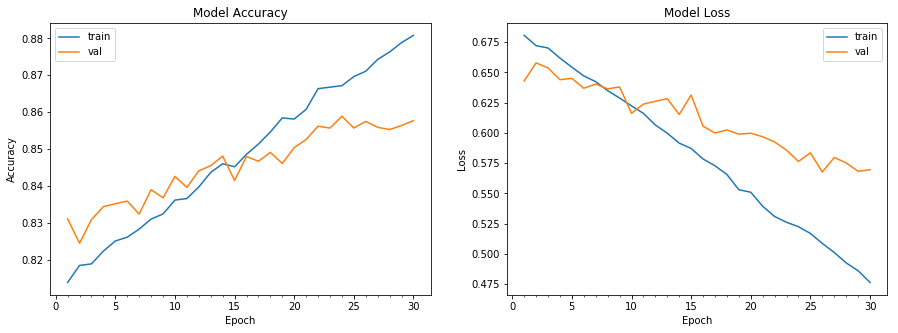

Accuracy on test data is: 85.77


In [23]:
# Model Execution is commented out to avoid re-running the model with same ('everything') architecture and parameters

'''
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(train_generator, shuffle=True,
                                 steps_per_epoch = len(train_features)//batch_size, epochs = 30, 
                                 validation_data = test_generator, validation_steps = test_steps, callbacks = [lr_schedule, checkpoint], verbose=1)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

'''

In [0]:
model.load_weights("/content/gdrive/My Drive/assignment9/A9A_ver4/weights-improvement-81-0.86.hdf5")

In [160]:
model.evaluate_generator(generator=test_generator, steps=test_steps)

[0.570178396254778, 0.8620999991893769]

In [0]:
# Helper functions
# preprocess_data() takes data ('train' or 'test') and num_idx (list of indices of data for which the grad-CAM is to be generated)
# preprocess_data() will only standardize the data, and outputs the standardized data along with the true labels for the given data.
# For convenience of identifying which data (train or test and what is the index) we used, it will also output the 
# datagroup (train/test) and set_data (those data selected from num_idx)


def preprocess_data(data, num_idx):
  if data == 'train':
    set_data = [x_train[i] for i in num_idx]
    true_labels = [y_train[i] for i in num_idx]
  elif data == 'test':
    set_data = [x_test[i] for i in num_idx]
    true_labels = [y_test[i] for i in num_idx]
  else:
    print("Wrong input to preprocess_data function. Input either 'train' or 'test' for data.")
    
  x = [np.expand_dims(i, axis=0) for i in set_data]
  # print([x[i].shape for i in range(len(num_idx))])
  x_stzd = [(i - train_datagen.mean) / (train_datagen.std + 1e-7) for i in x]
  true_labels = np.array(true_labels).tolist()
  true_labels = [item for sublist in true_labels for item in sublist]
  # xbar = np.concatenate(x_stzd, axis=0)
  return (data, set_data, x_stzd, true_labels)

# heatmap_calculate() takes the class_output (containing outputs specific to the predicted class), layer name (for which the heatmaps are to be generated), and the standardized data (output from preprocess_data())

def heatmap_calculate(class_output, calc_layer, xb):
  # class_output is the model.output results for the class predicted (for test_features) or the class (train_features)
  # calc_layer is the layer where the heatmap is calculated at. Entered as a string.
  # Usage: heatmap_calculate(class_output, "out_layer2")
  last_conv_layer = model.get_layer(calc_layer)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  # print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  pg_channels = pooled_grads.shape[0]
  # print(pooled_grads.shape, pg_channels)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  
  pooled_grads_value, conv_layer_output_value = iterate([xb])
  
  for i in range(pg_channels):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  # print(conv_layer_output_value.shape)
  # print(heatmap.shape)
  heatmap = np.maximum(heatmap, 1e-14)
  heatmap /= np.max(heatmap)
  return heatmap

In [162]:
datagroup, x_d, x_st, true_labels = preprocess_data('test', range(x_test.shape[0]))
test_generator.reset()
preds = model.predict_generator(generator=test_generator, steps = test_steps)
class_idx = [np.argmax(preds[i]) for i in range(x_test.shape[0])]
test_misclassified_labels = np.where(np.asarray(class_idx) != np.asarray(true_labels))[0]
print(1 - (test_misclassified_labels.shape[0] / 10000))

0.8621


These are the indices of 50 randomly selected test images (labels):  [7769 7956  982 1895 6553 9191 5207  427 8629 7414 3202 8491 5426 7620
 6901 8757 5162  665 3343 3382 3218 6545 2533 6517 1422 1623  323 4391
 4691 3753 4606 1185 7416 6533 4301 3459 5215 3752 6071 4147 3774 7430
 7906 2959 3110 6841 1057 3158 2844 9729]
The table below shows the grad-CAM implementation on CIFAR-10 images:


These are 50 randomly misclassified test images. The true-labels and misclassified labels are shown on top of each image



 Original image  	 	 Heatmaps 	 	 grad-CAM implemented image

 (with class label on top) 	 (gradCAM) 	 	 (with perdicted class label on top)


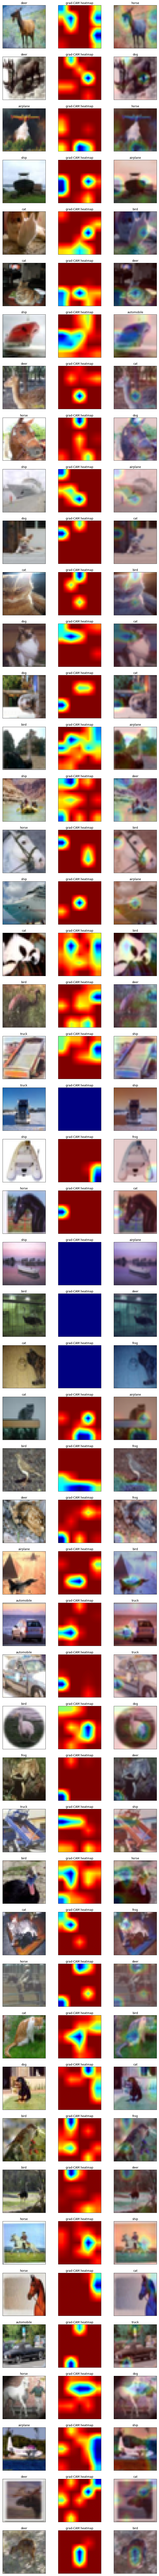

In [163]:
# This section will take inputs for implementation of grad-CAM on test dataset

ls_test = random.sample(list(test_misclassified_labels), 50)
print('These are the indices of 50 randomly selected test images (labels): ', np.array(ls_test))

datagroup, x_d, x_st, true_labels = preprocess_data('test', ls_test)

# preds = [model.predict(i) for i in x_st]
class_idx = [np.argmax(preds[i]) for i in ls_test]
class_output = [model.output[:, j] for j in class_idx]


heatmap_inputs = zip(class_output, x_st)

hmaps = [heatmap_calculate(cop, 'out_layer2', xb) for (cop, xb) in heatmap_inputs]
hmaps_rs = [cv2.resize(i, (200, 200)) for i in hmaps]
hmaps_rs = [np.uint8(255 * hs) for hs in hmaps_rs]
hmaps_rs = [cv2.applyColorMap(hs, cv2.COLORMAP_JET) for hs in hmaps_rs]
# [cv2_imshow(hs) for hs in hmaps_rs]

superimposed_test = [cv2.addWeighted(cv2.resize(x_d[i][:,:,::-1], (200, 200)), 0.8, hmaps_rs[i], 0.2, 0) for i in range(len(ls_test))]
# [cv2_imshow(superimposed_img[i]) for i in range(len(num_idx))]

fig = plt.figure(figsize=(12,4*len(ls_test)))

j = 1

print('The table below shows the grad-CAM implementation on CIFAR-10 images:')
print('\n')
print('These are 50 randomly misclassified test images. The true-labels and misclassified labels are shown on top of each image')
print('\n')
print('\n Original image  \t \t Heatmaps \t \t grad-CAM implemented image')
print('\n (with class label on top) \t (gradCAM) \t \t (with perdicted class label on top)')

for i in range(len(ls_test)):
  ax1 = fig.add_subplot(len(ls_test), 3, j, xticks=[], yticks=[])
  ax1.set_title(class_names[true_labels[i]])
  plt.imshow(x_d[i], 'jet')
  j = j + 1
  ax2 = fig.add_subplot(len(ls_test), 3, j, xticks=[], yticks=[])
  ax2.set_title('grad-CAM heatmap')
  plt.imshow(hmaps_rs[i], 'jet')
  j = j + 1
  ax3 = fig.add_subplot(len(ls_test), 3, j, xticks=[], yticks=[])
  ax3.set_title(class_names[class_idx[i]])
  plt.imshow(superimposed_test[i], 'jet')
  j = j + 1

# plt.tight_layout()
plt.show()

**Observation:** Some of the grad-CAM heatmaps obtained were plain bluish color. In my understanding this refers to the gradCAM getting no positive gradient values in the back propagation (that were attached to the object class).